In [1]:
from dolfin import *
from ufl import le
import operator
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Q-Tensor parameters
n = 2
num_steps = 200
T = 2.0
dt = T/num_steps
a = -0.3
b = -4.
c = 4.
M = 1.
L = 1.

# Parameters for electric field
R = 1.
eps2 = 0.5
eps3 = 0.01
eps1 = 2.5

# Parameters for convex splitting
beta1 = 8.
beta2 = 8.

In [3]:
# Create mesh
mesh = RectangleMesh(Point(-0.5, -0.5), Point(0.5, 0.5), 30, 30)

In [4]:
# some functions for the scheme
I = Constant(np.eye(n)) # identity matrix
Zero = 0 * I
Zero_func = 0*Function(FunctionSpace(mesh, "Lagrange", 1))

def dF1_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = beta1 * Q - b*(Q2 - 1/n * trQ2 * I) + beta2 * trQ2 * Q
    return result

def dF2_dQ(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    result = (beta1 - a) * Q + (beta2 - c) * trQ2 * Q
    return result

def F_tot(Q):
    Q2 = Q*Q
    trQ2 = tr(Q2)
    trQ3 = tr(Q2*Q)
    result = a/2 * trQ2 - b/3 * trQ3 + c/4 * trQ2**2
    return result

def tens(Q):
    """
    Make vector function into tensor
    """
    return as_tensor([[Q[0], Q[1]],
                      [Q[1], -1*Q[0]]])

def tens_hi(Q):
    return as_tensor([[Q[0], Q[1]],
                      [Zero_func, Zero_func]])

def tens_lo(Q):
    return as_tensor([[Zero_func, Zero_func],
                      [Q[0], Q[1]]])

## Initialize $Q_h^0$ and $u_h^0$

In [5]:
# initial conditions for the Q tensor
class InitialConditions(UserExpression):
    def eval(self, values, x):
        x, y = x[0], x[1]
        if np.isclose(x, -0.5) or np.isclose(x, 0.5) or np.isclose(y, -0.5) or np.isclose(y, 0.5):
            values[0] = 0.0
            values[1] = 0.0
        else:
            n0 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            n1 = (x+0.5)*(x-0.5)*(y+0.5)*(y-0.5)
            d = np.array([[n0], [n1]]) # director
            Q0 = d @ d.T - np.sum(d*d)/2.0 * np.eye(2) # Q tensor

            values[0] = Q0[0, 0]
            values[1] = Q0[0, 1]
    def value_shape(self):
        return (2,)

In [6]:
# initialize Q tensor at time 0
Q0 = Function(VectorFunctionSpace(mesh, "Lagrange", 1, dim=2))
Q_init = InitialConditions()
Q0.interpolate(Q_init)

# define uninitialized u0 and linear form to solve for u0
u_space = FunctionSpace(mesh, "Lagrange", 1)
u0 = Function(u_space)
v = TestFunction(u_space)

L_elliptic = inner(grad(u0) + eps2*tens(Q0)*grad(u0) + eps3*div(tens(Q0)), grad(v))*dx

# define boundary condition for u0
t = 0.0
u_b = Expression(f'10*exp({t})*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
bc_u = DirichletBC(u_space, u_b, DomainBoundary())

# solve for u0
solve(L_elliptic == 0, u0, bc_u)

No Jacobian form specified for nonlinear variational problem.
Differentiating residual form F to obtain Jacobian J = F'.
Solving nonlinear variational problem.
  Newton iteration 0: r (abs) = 3.658e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
  Newton iteration 1: r (abs) = 1.452e-14 (tol = 1.000e-10) r (rel) = 3.971e-16 (tol = 1.000e-09)
  Newton solver finished in 1 iterations and 1 linear solver iterations.


# Define and solve scheme

In [7]:
class QTensorEquation(NonlinearProblem):
    def __init__(self, L, a, bcs):
        NonlinearProblem.__init__(self)
        self.L = L
        self.a = a
        self.bcs = bcs
    def F(self, b, x):
        assemble(self.L, tensor=b)
        for bc in self.bcs:
            bc.apply(b,x)
    def J(self, A, x):
        assemble(self.a, tensor=A)
        for bc in self.bcs:
            bc.apply(A)

In [8]:
Q_space = VectorElement("Lagrange", mesh.ufl_cell(), 1, dim=2)
u_space = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
ME = MixedElement(Q_space, u_space)
V = FunctionSpace(mesh, ME)

In [9]:
# Define trial and test functions
dQu = TrialFunction(V)
q, v = TestFunctions(V)
r, _ = TestFunctions(V)

# Define functions
Qu = Function(V)

# Split mixed functions
dQ, du = split(dQu)
Q, u = split(Qu)

In [10]:
# Weak statement of the equation
# Note that we manually make trace free symmetric tensors
# using vector function spaces instead of using tensor functions
L_form = inner(tens(Q - Q0), tens_hi(q))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens_hi(q)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens_hi(q))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens_hi(q))*dx\
    - M*eps2*dt/2*inner(outer(grad(u0), grad(u)) - (1/n)*tr(outer(grad(u0), grad(u)))*I, tens_hi(q))*dx\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_hi(q))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens_hi(q))))*dx)\
    + inner(tens(Q - Q0), tens_lo(r))*dx\
    + M*L*dt/2*inner(grad(tens(Q+Q0)), grad(tens_lo(r)))*dx\
    + M*dt*inner(dF1_dQ(tens(Q)), tens_lo(r))*dx\
    - M*dt*inner(dF2_dQ(tens(Q0)), tens_lo(r))*dx\
    - M*eps2*dt/2*inner(outer(grad(u0), grad(u)) - (1/n)*tr(outer(grad(u0), grad(u)))*I, tens_lo(r))*dx\
    - M*eps3*dt/2*(inner(grad(u+u0), div(sym(tens_lo(r))))*dx - (1/n)*inner(grad(u+u0), grad(tr(tens_lo(r))))*dx)\
    + inner(grad(u) + eps2*tens(Q)*grad(u) + eps3*div(tens(Q)), grad(v))*dx

a_form = derivative(L_form, Qu, dQu)

In [11]:
# boundary conditions for Q do not change
bc_Q = DirichletBC(V.sub(0), np.zeros(2), DomainBoundary())

# Store solutions and times
Q_array = Q0.vector()[:].reshape(-1, 2)
Q_11 = Q_array[:, 0]
Q_12 = Q_array[:, 1]
solutions_Q = [np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1)]
solutions_u = [np.array(u0.vector()[:].reshape(-1, 1))]
times = [0.0]

solver = NewtonSolver()

t = 0.0
while (t < T):
    print(t)
    t += dt
    times.append(t)
    
    u_b = Expression(f'10*exp({t})*sin({2*np.pi*t+0.2})*(x[0]+0.5)*sin({np.pi}*x[1])', degree=2)
    bc_u = DirichletBC(V.sub(1), u_b, DomainBoundary())
    
    problem = QTensorEquation(L_form, a_form, [bc_Q, bc_u])
    solver.solve(problem, Qu.vector())
    
    Q_array = Qu.sub(0, deepcopy=True).vector()[:].reshape(-1, 2)
    Q_11 = Q_array[:, 0]
    Q_12 = Q_array[:, 1]
    
    solutions_Q.append(np.array([[Q_11, Q_12], [Q_12, -Q_11]]).transpose(2, 0, 1))
    solutions_u.append(np.array(Qu.sub(1, deepcopy=True).vector()[:].reshape(-1, 1)))
    
    Q0.vector()[:] = np.ascontiguousarray(Qu.sub(0, deepcopy=True).vector()[:])
    u0.vector()[:] = np.ascontiguousarray(Qu.sub(1, deepcopy=True).vector()[:])

0.0
Newton iteration 0: r (abs) = 1.553e+01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.330e-03 (tol = 1.000e-10) r (rel) = 2.145e-04 (tol = 1.000e-09)
0.01
Newton iteration 2: r (abs) = 1.329e-08 (tol = 1.000e-10) r (rel) = 8.558e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 3.785e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 8.333e-04 (tol = 1.000e-10) r (rel) = 2.202e-04 (tol = 1.000e-09)
0.02
Newton iteration 2: r (abs) = 2.523e-09 (tol = 1.000e-10) r (rel) = 6.666e-10 (tol = 1.000e-09)
Newton solver finished in 2 iterations and 2 linear solver iterations.
Newton iteration 0: r (abs) = 3.783e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
0.03
Newton iteration 1: r (abs) = 9.842e-04 (tol = 1.000e-10) r (rel) = 2.602e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 3.266e-09 (tol = 1.000e-10) r (rel) = 8.6

Newton iteration 1: r (abs) = 5.165e-04 (tol = 1.000e-10) r (rel) = 3.780e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.429e-08 (tol = 1.000e-10) r (rel) = 1.046e-08 (tol = 1.000e-09)
0.20000000000000004
Newton iteration 3: r (abs) = 2.714e-14 (tol = 1.000e-10) r (rel) = 1.986e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 1.101e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.569e-04 (tol = 1.000e-10) r (rel) = 3.243e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 8.670e-09 (tol = 1.000e-10) r (rel) = 7.877e-09 (tol = 1.000e-09)
0.21000000000000005
Newton iteration 3: r (abs) = 2.634e-14 (tol = 1.000e-10) r (rel) = 2.393e-14 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 8.249e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 2.228e-04 (tol = 1.0

Newton iteration 1: r (abs) = 3.145e-03 (tol = 1.000e-10) r (rel) = 6.905e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.123e-07 (tol = 1.000e-10) r (rel) = 4.662e-08 (tol = 1.000e-09)
0.4000000000000002
Newton iteration 3: r (abs) = 2.110e-14 (tol = 1.000e-10) r (rel) = 4.632e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 4.797e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.316e-03 (tol = 1.000e-10) r (rel) = 6.913e-04 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 2.282e-07 (tol = 1.000e-10) r (rel) = 4.757e-08 (tol = 1.000e-09)
0.4100000000000002
Newton iteration 3: r (abs) = 1.754e-14 (tol = 1.000e-10) r (rel) = 3.657e-15 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 5.024e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 3.405e-03 (tol = 1.000

Newton iteration 1: r (abs) = 7.008e-03 (tol = 1.000e-10) r (rel) = 1.203e-03 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 8.751e-07 (tol = 1.000e-10) r (rel) = 1.502e-07 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 1.598e-12 (tol = 1.000e-10) r (rel) = 2.743e-13 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
0.5800000000000003
Newton iteration 0: r (abs) = 5.665e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 7.013e-03 (tol = 1.000e-10) r (rel) = 1.238e-03 (tol = 1.000e-09)
0.5900000000000003
Newton iteration 2: r (abs) = 1.023e-06 (tol = 1.000e-10) r (rel) = 1.805e-07 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 3.250e-12 (tol = 1.000e-10) r (rel) = 5.736e-13 (tol = 1.000e-09)
Newton solver finished in 3 iterations and 3 linear solver iterations.
Newton iteration 0: r (abs) = 5.477e+00 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 6.826e-03 (tol = 1.000

Newton iteration 1: r (abs) = 1.692e-03 (tol = 1.000e-10) r (rel) = 1.975e-02 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 1.332e-05 (tol = 1.000e-10) r (rel) = 1.555e-04 (tol = 1.000e-09)
0.7500000000000004
Newton iteration 3: r (abs) = 1.656e-09 (tol = 1.000e-10) r (rel) = 1.932e-08 (tol = 1.000e-09)
Newton iteration 4: r (abs) = 4.292e-14 (tol = 1.000e-10) r (rel) = 5.010e-13 (tol = 1.000e-09)
Newton solver finished in 4 iterations and 4 linear solver iterations.
Newton iteration 0: r (abs) = 5.892e-01 (tol = 1.000e-10) r (rel) = 1.000e+00 (tol = 1.000e-09)
Newton iteration 1: r (abs) = 7.226e-04 (tol = 1.000e-10) r (rel) = 1.226e-03 (tol = 1.000e-09)
Newton iteration 2: r (abs) = 9.237e-06 (tol = 1.000e-10) r (rel) = 1.568e-05 (tol = 1.000e-09)
Newton iteration 3: r (abs) = 7.574e-10 (tol = 1.000e-10) r (rel) = 1.286e-09 (tol = 1.000e-09)
0.7600000000000005
Newton iteration 4: r (abs) = 4.584e-14 (tol = 1.000e-10) r (rel) = 7.781e-14 (tol = 1.000e-09)
Newton solver finished in 4

Newton iteration 42: r (abs) = 1.045e+20 (tol = 1.000e-10) r (rel) = 3.277e+19 (tol = 1.000e-09)
Newton iteration 43: r (abs) = 2.137e+22 (tol = 1.000e-10) r (rel) = 6.702e+21 (tol = 1.000e-09)
Newton iteration 44: r (abs) = 8.472e+21 (tol = 1.000e-10) r (rel) = 2.657e+21 (tol = 1.000e-09)
Newton iteration 45: r (abs) = 2.627e+21 (tol = 1.000e-10) r (rel) = 8.240e+20 (tol = 1.000e-09)
Newton iteration 46: r (abs) = 2.139e+23 (tol = 1.000e-10) r (rel) = 6.709e+22 (tol = 1.000e-09)
Newton iteration 47: r (abs) = 4.773e+22 (tol = 1.000e-10) r (rel) = 1.497e+22 (tol = 1.000e-09)
Newton iteration 48: r (abs) = 1.264e+23 (tol = 1.000e-10) r (rel) = 3.965e+22 (tol = 1.000e-09)
Newton iteration 49: r (abs) = 2.990e+23 (tol = 1.000e-10) r (rel) = 9.378e+22 (tol = 1.000e-09)
Newton iteration 50: r (abs) = 2.297e+26 (tol = 1.000e-10) r (rel) = 7.205e+25 (tol = 1.000e-09)


RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2019.2.0.dev0
*** Git changeset:  unknown
*** -------------------------------------------------------------------------


# Visualize solution

In [12]:
solutions_u = np.array(solutions_u)
solutions_Q = np.array(solutions_Q) # time x mesh size x rows x cols

In [13]:
# turn solutions into time series of vector field and use plot command from FEniCS
directors = np.zeros((solutions_Q.shape[0], solutions_Q.shape[1], 2, 1))
for time in range(solutions_Q.shape[0]):
    for point in range(solutions_Q.shape[1]):
        Q_tensor = solutions_Q[time, point]
        eigenvalues, eigenvectors = np.linalg.eigh(Q_tensor)
        v1 = eigenvectors[:, 0]
        v2 = eigenvectors[:, 1]
        if np.sum(np.abs(Q_tensor)) > 1e-6:
            director1x = v1[0]
            director1y = v1[1]
            director2x = v2[0]
            director2y = v2[1]
            directors[time, point] = v2.reshape(-1, 1)
        else:
            directors[time, point] = np.zeros((2, 1))

0.00


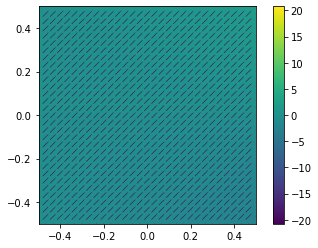

0.01


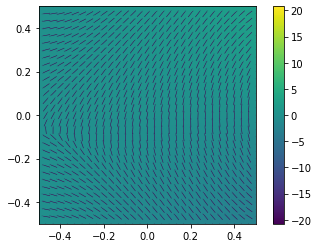

0.02


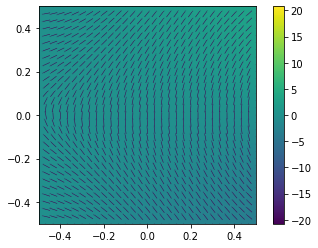

0.03


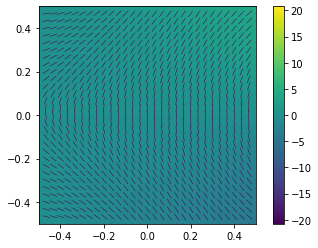

0.04


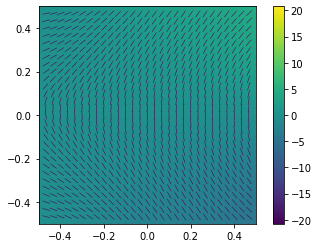

0.05


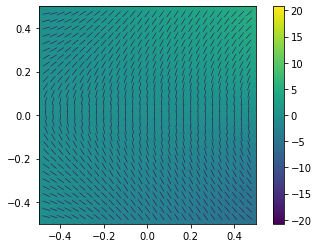

0.06


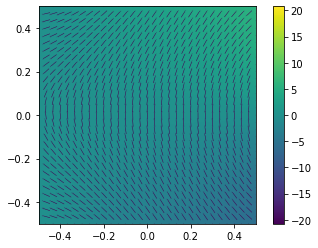

0.07


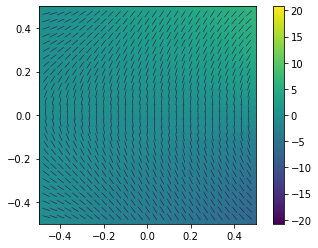

0.08


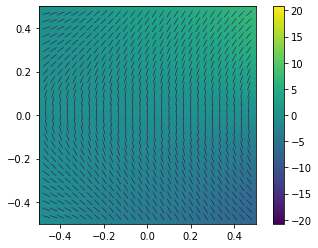

0.09


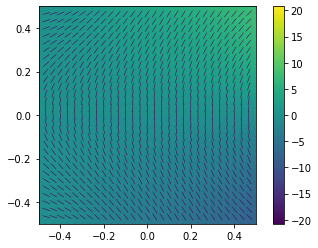

0.10


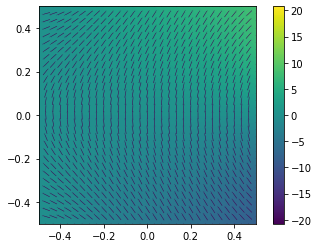

0.11


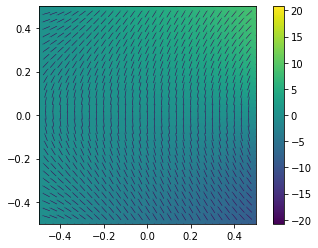

0.12


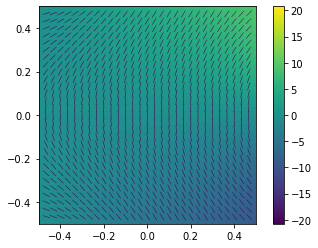

0.13


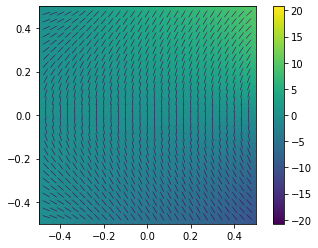

0.14


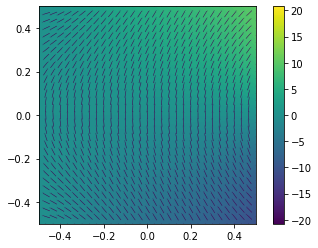

0.15


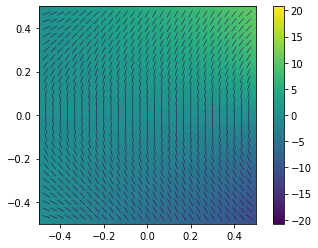

0.16


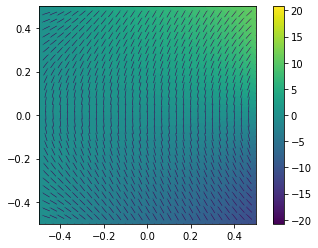

0.17


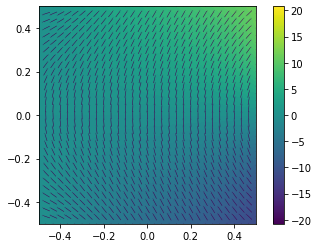

0.18


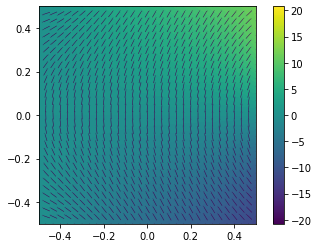

0.19


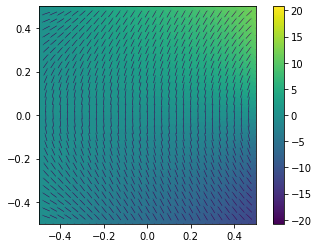

0.20


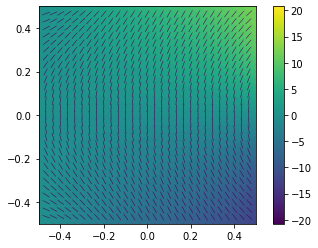

0.21


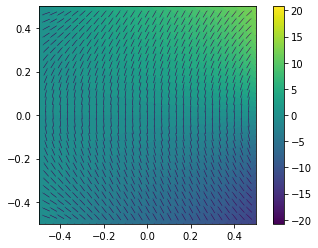

0.22


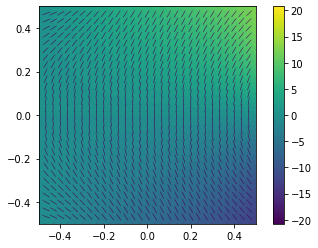

0.23


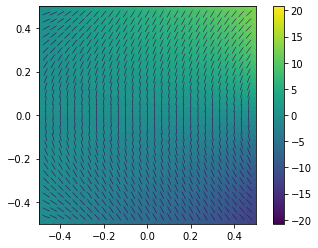

0.24


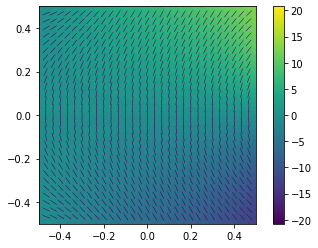

0.25


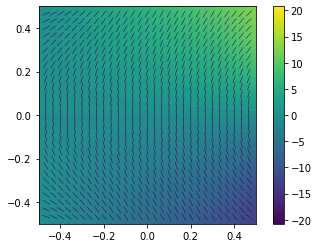

0.26


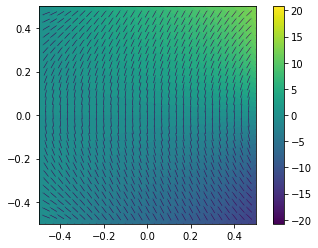

0.27


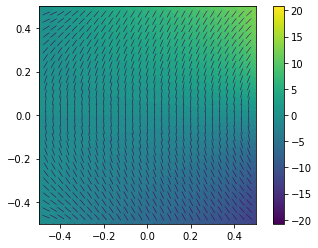

0.28


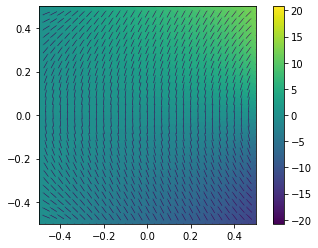

0.29


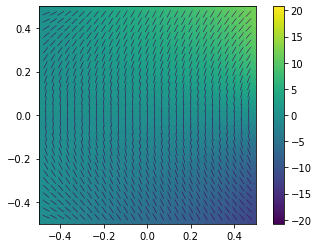

0.30


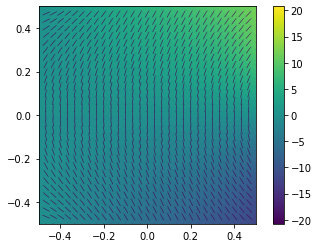

0.31


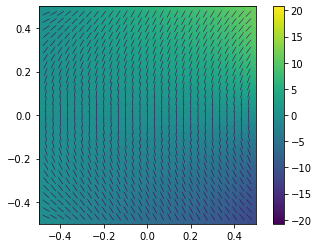

0.32


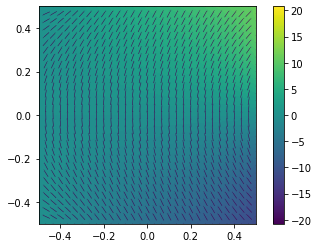

0.33


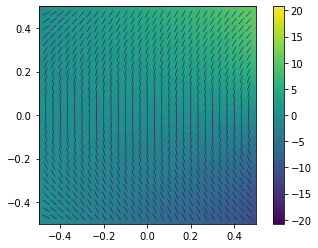

0.34


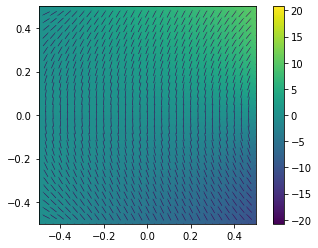

0.35


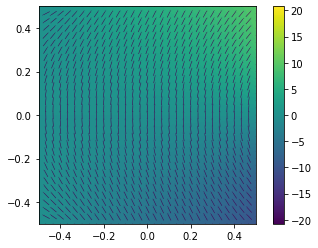

0.36


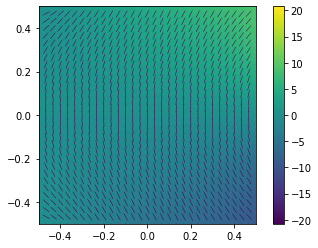

0.37


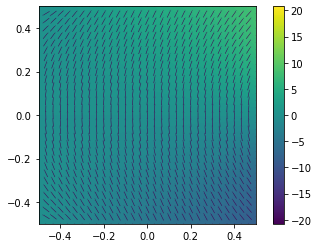

0.38


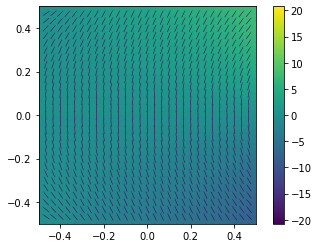

0.39


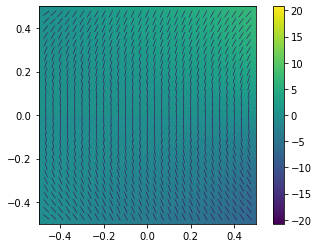

0.40


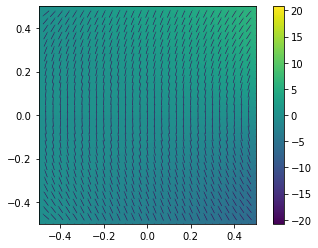

0.41


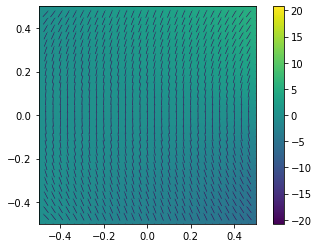

0.42


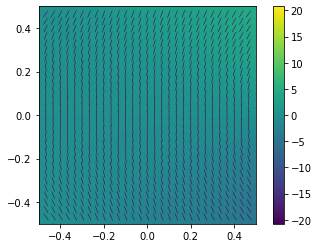

0.43


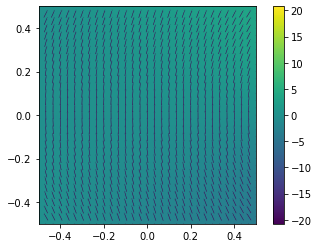

0.44


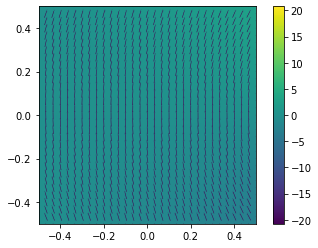

0.45


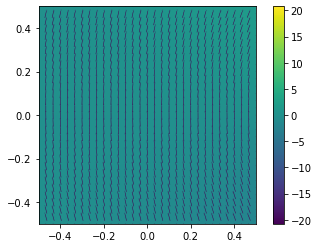

0.46


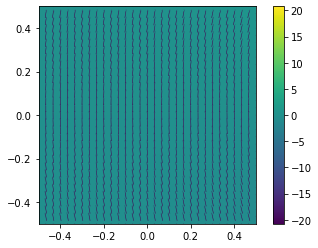

0.47


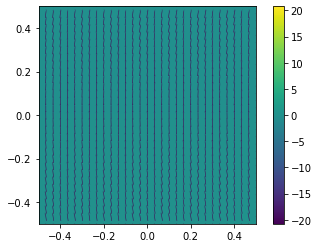

0.48


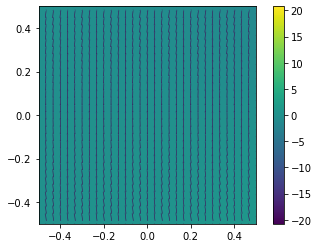

0.49


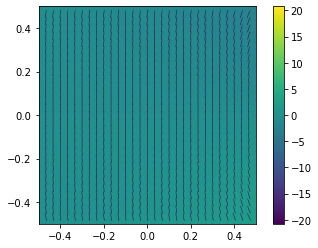

0.50


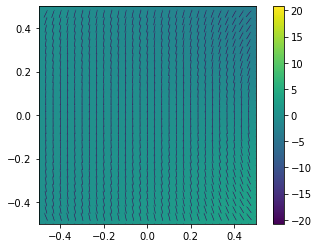

0.51


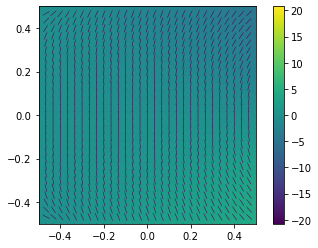

0.52


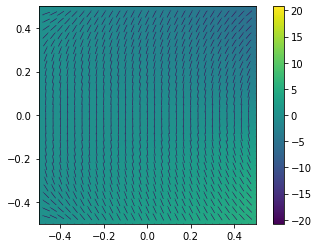

0.53


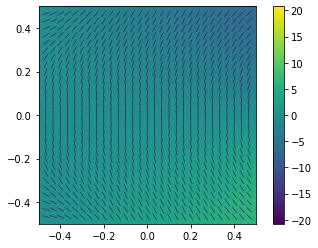

0.54


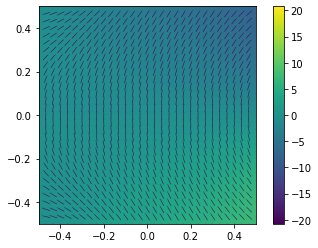

0.55


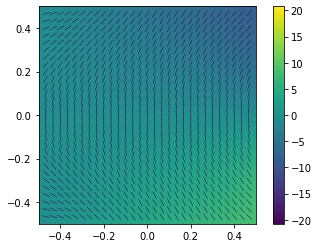

0.56


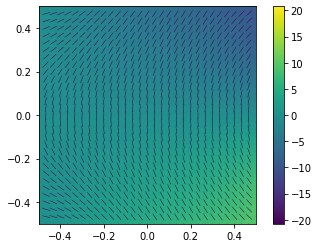

0.57


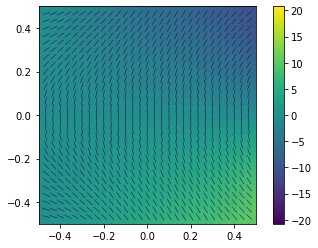

0.58


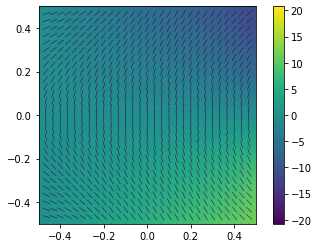

0.59


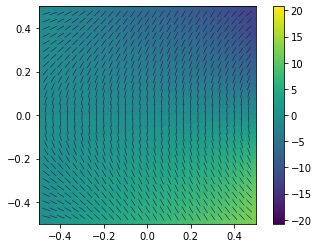

0.60


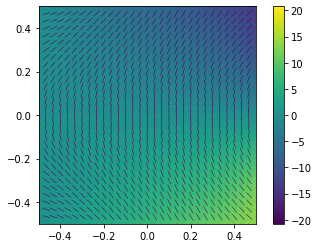

0.61


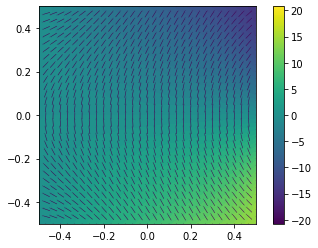

0.62


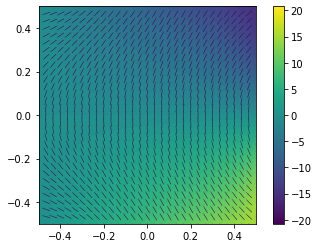

0.63


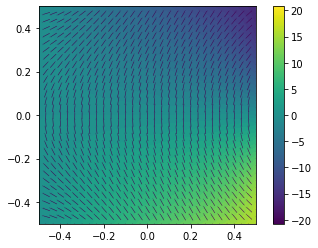

0.64


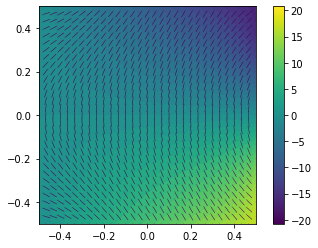

0.65


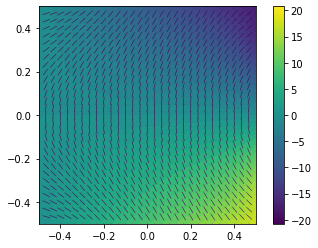

0.66


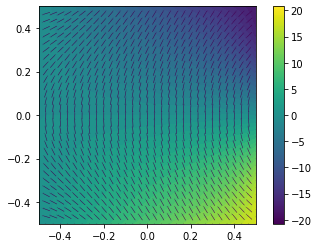

0.67


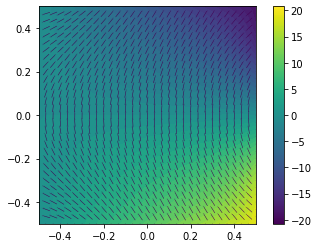

0.68


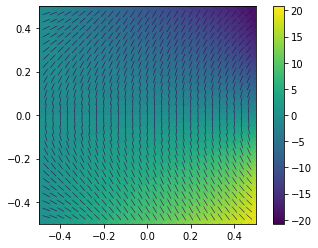

0.69


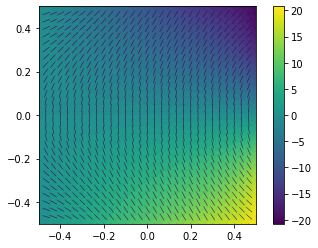

0.70


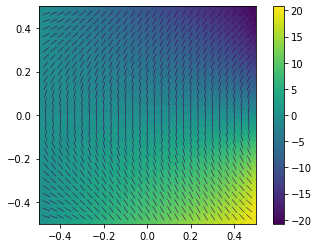

0.71


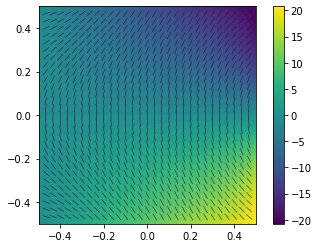

0.72


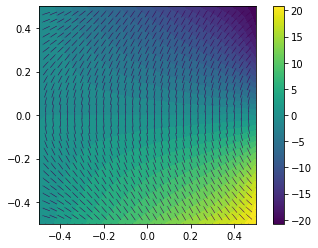

0.73


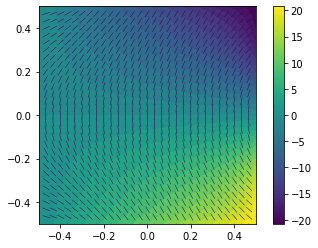

0.74


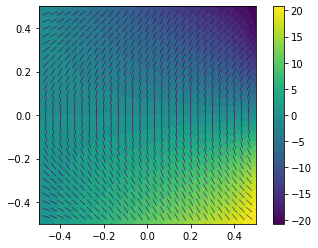

0.75


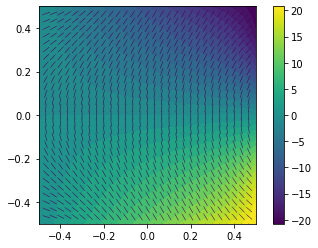

0.76


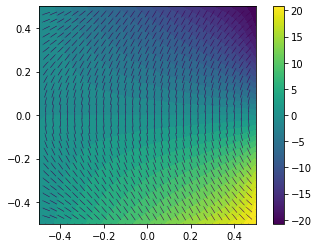

0.77


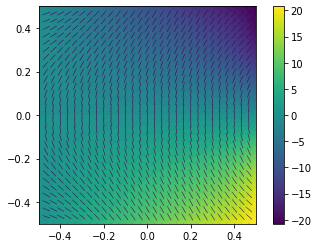

0.78


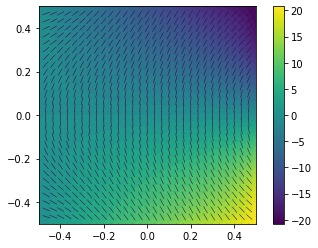

0.79


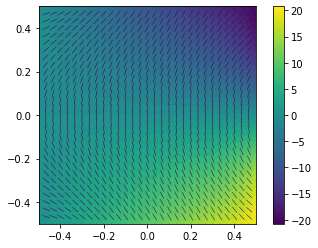

0.80


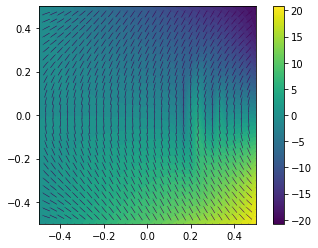

In [14]:
DirectorSpace = VectorFunctionSpace(mesh, "Lagrange", 1, dim=n)
D0 = Function(DirectorSpace)
u1 = Function(FunctionSpace(mesh, "Lagrange", 1))
for time in range(directors.shape[0]):
    fig, ax = plt.subplots(1, 1)
    
    u1.vector()[:] = np.ascontiguousarray(solutions_u[time].reshape(-1))
    out = plot(u1, vmin=np.min(solutions_u), vmax=np.max(solutions_u))
    
    D0.vector()[:] = np.ascontiguousarray(directors[time].reshape(-1))
    out = plot(D0, scale=25., pivot='mid', clim=(0., 0.), headaxislength=0)
    
    fraction = 1  # .05
    norm = mpl.colors.Normalize(vmin=np.min(solutions_u), vmax=np.max(solutions_u))
    cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=out.ax)
    
    print(f"{times[time]:.2f}")
    plt.show()

# Look at eigenvalues and entries of Q tensors

In [15]:
eigenvalue_1 = []
eigenvalue_2 = []
for time_i in range(solutions_Q.shape[0]):
    eigenvalue_1.append([])
    eigenvalue_2.append([])
    for vertex in range(solutions_Q.shape[1]):
        w, v = np.linalg.eigh(solutions_Q[time_i, vertex])
        eigenvalue_1[-1].append(w[0])
        eigenvalue_2[-1].append(w[1])

In [16]:
max_entries_tQ = []
max_entries_t = []
for time_i in range(solutions_Q.shape[0]):
    max_entries_tQ.append([])
    for vertex in range(solutions_Q.shape[1]):
        max_entries_tQ[-1].append(np.max(np.abs(solutions_Q[time_i, vertex])))
    max_entries_t.append(np.max(max_entries_tQ[-1]))

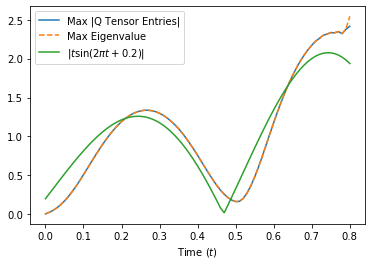

In [17]:
plt.plot(np.arange(len(max_entries_t))*dt, max_entries_t, label='Max |Q Tensor Entries|')
plt.plot(np.arange(len(eigenvalue_2))*dt, np.max(eigenvalue_2, axis=1), linestyle='--', label='Max Eigenvalue')
plt.plot(np.arange(len(max_entries_t))*dt, np.abs(np.exp(np.arange(len(max_entries_t))*dt)*np.sin(2*np.pi*np.arange(len(max_entries_t))*dt+0.2)), label='$|t\sin(2\pi t+0.2)|$')
plt.xlabel("Time ($t$)")
plt.legend()
plt.show()

In [18]:
max_entries_t[-5:]

[2.3320688206653357,
 2.348638142156044,
 2.321173887877976,
 2.3778596620830528,
 2.416459201470884]